# DQN for Ms Pacman

TLDR: 

## Table of Content

## Imports

In [2]:
import collections
import random
import time
import warnings

import cv2 as cv
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from src.DQN import DQN
from src.ReplayBuffer import ReplayBuffer
from src.utils import preprocess_state

# for windows
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for mac
device = torch.device(
    "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)

warnings.simplefilter("ignore")
np.random.seed(42)

## Environment

In [3]:
ENV_NAME = "ALE/MsPacman-v5"
env = gym.make(ENV_NAME, render_mode="rgb_array")

print("Observation Space: ", env.observation_space)
print("Action Space: ", env.action_space)
print("Actions: ", env.get_action_meanings())

Observation Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space:  Discrete(9)
Actions:  ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


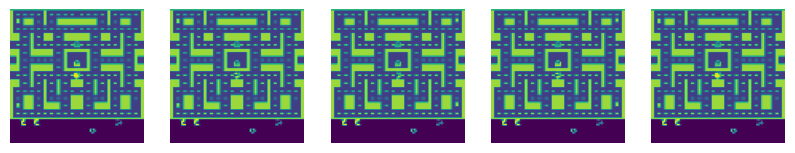

In [4]:
obs, info = env.reset()

fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=5)
for i in range(5):
    obs, reward, done, trunc, info = env.step(env.action_space.sample())
    obs = preprocess_state(obs, stack_states=False, create_tensor=False)

    axes[i].imshow(obs)
    axes[i].axis("off")


env.close()

## Train Agent

### Set Parameter

In [5]:
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 1000
LEARNING_RATE = 1e-4
REPLAY_SIZE = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 10
N_EPISODES = 2
N_STACKED_FRAMES = 4
INPUT_SHAPE = (4, 84, 84)

# create experience tuple template
Experience = collections.namedtuple(
    "Exoeruebce", field_names=["state", "action", "reward", "done", "next_state"]
)

In [6]:
env = gym.make(ENV_NAME, render_mode="rgb_array")

dqn = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net.load_state_dict(dqn.state_dict())
target_net.eval()

optimizer = optim.Adam(dqn.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(capacity=REPLAY_SIZE)

In [21]:
# training loop
history = list()
epsilon = EPSILON_START
frame_idx = 0

for episode in tqdm(range(N_EPISODES + 1)):
    state, info = env.reset()
    state = preprocess_state(
        state, stack_states=True, stack_size=N_STACKED_FRAMES, create_tensor=True
    ).to(device)

    done = False
    total_reward = 0
    while not done:

        frame_idx += 1

        # use epsilon greedy strategy to select action
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space.n)
        else:
            action = dqn(state).argmax().item()

        # act in environment
        next_state, reward, done, _, info = env.step(action)
        # preprocess state
        next_state = preprocess_state(
            next_state,
            stack_states=True,
            stack_size=N_STACKED_FRAMES,
            create_tensor=True,
        ).to(device)
        total_reward += reward

        # store information in replay buffer
        exp = Experience(state, action, reward, done, next_state)
        replay_buffer.push(exp)
        state = next_state

        # restore experiences from replay buffer
        if replay_buffer.size > BATCH_SIZE:
            (
                sample_states,
                sample_actions,
                sample_rewards,
                sample_dones,
                sample_next_states,
            ) = replay_buffer.sample(BATCH_SIZE)

            sample_states = torch.cat(sample_states).to(device)
            sample_actions = torch.LongTensor(sample_actions).to(device)
            sample_rewards = torch.FloatTensor(sample_rewards).to(device)
            sample_next_states = torch.cat(sample_next_states).to(device)
            sample_dones = torch.FloatTensor(sample_dones).to(device)

            q_curr_state = (
                dqn(sample_states).gather(1, sample_actions.unsqueeze(-1)).squeeze(1)
            )
            q_next_state = target_net(sample_next_states).max(dim=1)[0]
            expected_q = sample_rewards + GAMMA * q_next_state * sample_dones

            loss = nn.MSELoss()(q_curr_state, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # update target network
        if frame_idx % TARGET_UPDATE == 0:
            target_net.load_state_dict(dqn.state_dict())

        # update epsilon
        epsilon = max(EPSILON_END, EPSILON_START - frame_idx / EPSILON_DECAY)

    history.append(total_reward)

env.close()

torch.save(dqn.state_dict(), "dqn.pth")

100%|██████████| 3/3 [00:12<00:00,  4.17s/it]


230.0

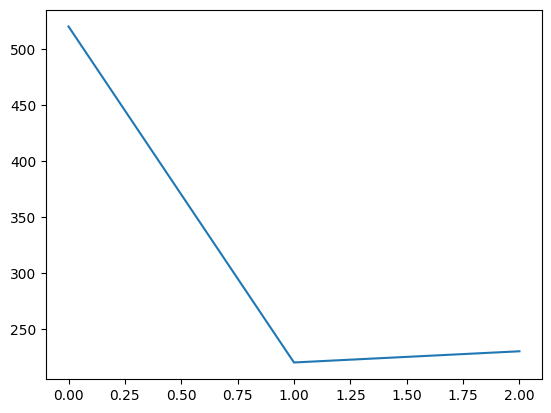

In [24]:
plt.plot(history)